<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

# A1: Classification Model Development

**Author:** Max Lembke 

**Course:** Machine Learning - DAT-5303

**Date:** 02/14/2021

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" />

##  1) Set-up & Data Preparation 

### a) Import of Libraries & File 

In [1]:
# Importing libraries
import pandas as pd # data science essentials
import numpy as np #math esstentials 
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # enhanced data visualization
from sklearn.model_selection import train_test_split # train/test split
from sklearn.metrics import roc_auc_score # roc 
from sklearn.tree import DecisionTreeClassifier # for decision tree
from sklearn import tree # for trees 
from sklearn.metrics import confusion_matrix # for matrix
from sklearn.model_selection import RandomizedSearchCV # for search parameters 
from sklearn.metrics import make_scorer # for scoring 
from sklearn.ensemble import GradientBoostingClassifier # for GBM
from sklearn.tree import DecisionTreeClassifier # classification trees
from sklearn.tree import export_graphviz # exports graphics
from six import StringIO # saves objects in memory
from IPython.display import Image # displays on frontend
import pydotplus  # interprets dot objects


# Setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Importing file 
file = "./Apprentice_Chef_Dataset.xlsx"

# Reading file 
df_all = pd.read_excel(file)

# Lowercase column names to make typing in the future easier
df_all.columns = map(str.lower, df_all.columns)

# Renaming mislabled 
df_all = df_all.rename(columns = {'largest_order_size':'avg_num_meals_customer'})


# Checking for nulls and imputing 0 
#df_all.isnull().sum(axis = 0) 
df_all = df_all.fillna(0) #impute 0 for no data
#df_all.isnull().sum(axis = 0) #check if removed

# Show head to verify renaming, loading of data and other transformations worked 
df_all.head(n=5)


,revenue,cross_sell_success,name,email,first_name,family_name,total_meals_ordered,unique_meals_purch,contacts_w_customer_service,product_categories_viewed,avg_time_per_site_visit,mobile_number,cancellations_before_noon,cancellations_after_noon,tastes_and_preferences,pc_logins,mobile_logins,weekly_plan,early_deliveries,late_deliveries,package_locker,refrigerated_locker,avg_prep_vid_time,avg_num_meals_customer,master_classes_attended,median_meal_rating,avg_clicks_per_visit,total_photos_viewed
0,393.0,1,Saathos,saathos@unitedhealth.com,Saathos,Saathos,14,6,12,10,48.00,1,3,1,1,5,2,0,0,2,0,0,33.4,1,0,1,17,0
1,1365.0,1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,Osgrey,87,3,8,8,40.35,1,0,0,1,5,1,12,0,2,0,0,84.8,1,0,3,13,170
2,800.0,1,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,Fossoway,15,7,11,5,19.77,1,3,0,1,6,1,1,0,1,0,0,63.0,1,0,2,16,0
3,600.0,1,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,Westerling,13,6,11,5,90.00,1,2,0,1,6,1,14,0,3,0,0,43.8,1,0,2,14,0
4,1490.0,1,Elyn Norridge,elyn.norridge@jnj.com,Elyn,Norridge,47,8,6,10,40.38,1,0,0,0,5,1,5,0,8,0,0,84.8,1,1,3,12,205


### b) Helper Functions 

In [2]:
#########################
# text_split_feature
#########################
        
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
        

########################################
# display_tree
########################################
def display_tree(tree, feature_df, height = 500, width = 800):
    """
    PARAMETERS
    ----------
    tree       : fitted tree model object
        fitted CART model to visualized
    feature_df : DataFrame
        DataFrame of explanatory features (used to generate labels)
    height     : int, default 500
        height in pixels to which to constrain image in html
    width      : int, default 800
        width in pixels to which to constrain image in html
    """

    # visualizing the tree
    dot_data = StringIO()

    
    # exporting tree to graphviz
    export_graphviz(decision_tree      = tree,
                    out_file           = dot_data,
                    filled             = True,
                    rounded            = True,
                    special_characters = True,
                    feature_names      = feature_df.columns)


    # declaring a graph object
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())


    # creating image
    img = Image(graph.create_png(),
                height = height,
                width  = width)
    
    return img

########################################
# visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

### c) Feature Engineering 

In [3]:
## Self-made Features ##

# Total Cancellations 
df_all['total_cancel'] = df_all['cancellations_before_noon'] + df_all['cancellations_after_noon']

# Total Cancellations 
df_all['avg_cancellations'] = (df_all['cancellations_before_noon'] + df_all['cancellations_after_noon'])/2

# Total logins 
df_all['total_logins'] = df_all['pc_logins'] + df_all['mobile_logins']

# Amount of names 
text_split_feature(col = 'name', df = df_all, 
                   new_col_name = 'amount_of_names')

In [4]:
## Mail Feature ## 

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in df_all.iterrows():
    
    # splitting email domain at '@'
    split_email = df_all.loc[index, 'email'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = ['0' , 'domain']

# concatenating domain with df_all
df_all = pd.concat([df_all, email_df['domain']],
                     axis = 1)

# creating column to be allocated with email type 
df_all['mail_type'] = '0'


# defintion of email types 

prof = ['walmart.com','mmm.com', 'pg.com',
        'amex.com', 'apple.com','boeing.com', 
        'caterpillar.com', 'chevron.com',
        'cisco.com', 'cocacola.com', 'disney.com', 
        'dupont.com', 'exxon.com', 'ge.org', 
        'goldmansacs.com', 'homedepot.com', 'ibm.com', 
        'intel.com', 'jnj.com', 'jpmorgan.com', 
        'mcdonalds.com', 'merck.com', 'microsoft.com', 
        'nike.com', 'pfizer.com', 
        'travelers.com', 'unitedtech.com', 'unitedhealth.com',
        'verizon.com', 'visa.com']

pers = ['gmail.com','protonmail.com','yahoo.com']

spam = ['hotmail.com','me.com', 'msn.com','live.com', 'passport.com','aol.com']

# loop for classification 

for index, row in df_all.iterrows():
    if df_all.loc[index,'domain'] in prof: 
        df_all.loc[index,'mail_type'] = 'professional'
        
    elif df_all.loc[index,'domain'] in pers: 
        df_all.loc[index,'mail_type'] = 'personal'
        
    elif df_all.loc[index,'domain'] in spam: 
        df_all.loc[index,'mail_type'] = 'spam'
    
    elif df_all.loc[index, 'domain'] not in prof or df_all.loc[
            row, 'domain'] not in pers or df_all.loc[row, 'domain'] not in spam:
        df_all.loc[index, 'mail_type'] = 'unknown'
    
    else:
        print('Mistake')

# creating dummies based on email type 
mail_dummies = pd.get_dummies(df_all.mail_type, prefix = "dum_mail_type") 

# adding dummies to main dataframe 
df_all = pd.concat([df_all,mail_dummies], axis = 1)

In [5]:
## Dummies ## 

# creating dummies based on rating
rating_dummies = pd.get_dummies(df_all.median_meal_rating,prefix = "dum_median_rating",drop_first = True)

# adding dummies to main dataframe 
df_all = pd.concat([df_all,rating_dummies], axis = 1)

# 2) Classification Model 

## a) Preparation 

In [6]:
# Defining final variables 
final_variables = ['cancellations_before_noon',
'mobile_logins',
'avg_prep_vid_time',
'amount_of_names',
'dum_mail_type_spam',
'dum_mail_type_professional',
'total_logins',
'avg_prep_vid_time',
'contacts_w_customer_service',
'tastes_and_preferences',
'pc_logins',
'total_meals_ordered',
'unique_meals_purch',
'dum_median_rating_2',
'dum_median_rating_3',
'dum_median_rating_4',
'dum_median_rating_5',
'amount_of_names',
'refrigerated_locker',
'package_locker',
'mobile_number']

In [7]:
# declaring explanatory variables
df_data = df_all.loc[ :  , final_variables]

# declaring response variable
df_target = df_all.loc[ :  ,'cross_sell_success']

# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            df_data,
            df_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = df_target)

## b) Decision Tree

### i) Base Model

In [8]:
# INSTANTIATING a classification tree object
full_tree = DecisionTreeClassifier(criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 25,
                                    random_state     = 219)


# FITTING the training data
full_tree_fit = full_tree.fit(x_train, y_train)


# PREDICTING on new data
full_tree_pred = full_tree_fit.predict(x_test)


# SCORING the model
print('Full Tree Training Accuracy:', full_tree_fit.score(x_train,
                                                    y_train).round(4))

print('Full Tree Testing Accuracy :', full_tree_fit.score(x_test,
                                                    y_test).round(4))
print('Full Tree Gap Training/Testing:', ((full_tree_fit.score(x_train,
                                                    y_train))-
                                          (full_tree_fit.score(x_test,
                                                    y_test))).round(4))

print('Full Tree AUC Score:', roc_auc_score(y_true  = y_test,
                                            y_score = full_tree_pred).round(4))


# Saving for table 
ft_1 = (full_tree_fit.score(x_train, y_train).round(4))

ft_2 = (full_tree_fit.score(x_test, y_test).round(4))

ft_3 = (((full_tree_fit.score(x_train,y_train))-(full_tree_fit.score(x_test, y_test))).round(4))

ft_4 = (roc_auc_score(y_true  = y_test, y_score = full_tree_pred).round(4))

# saving scoring data for future use
full_tree_train_score = full_tree_fit.score(x_train, y_train).round(4) # accuracy
full_tree_test_score  = full_tree_fit.score(x_test, y_test).round(4)   # accuracy


# saving AUC
full_tree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = full_tree_pred).round(4) # auc

Full Tree Training Accuracy: 0.7601
Full Tree Testing Accuracy : 0.7721
Full Tree Gap Training/Testing: -0.012
Full Tree AUC Score: 0.7018


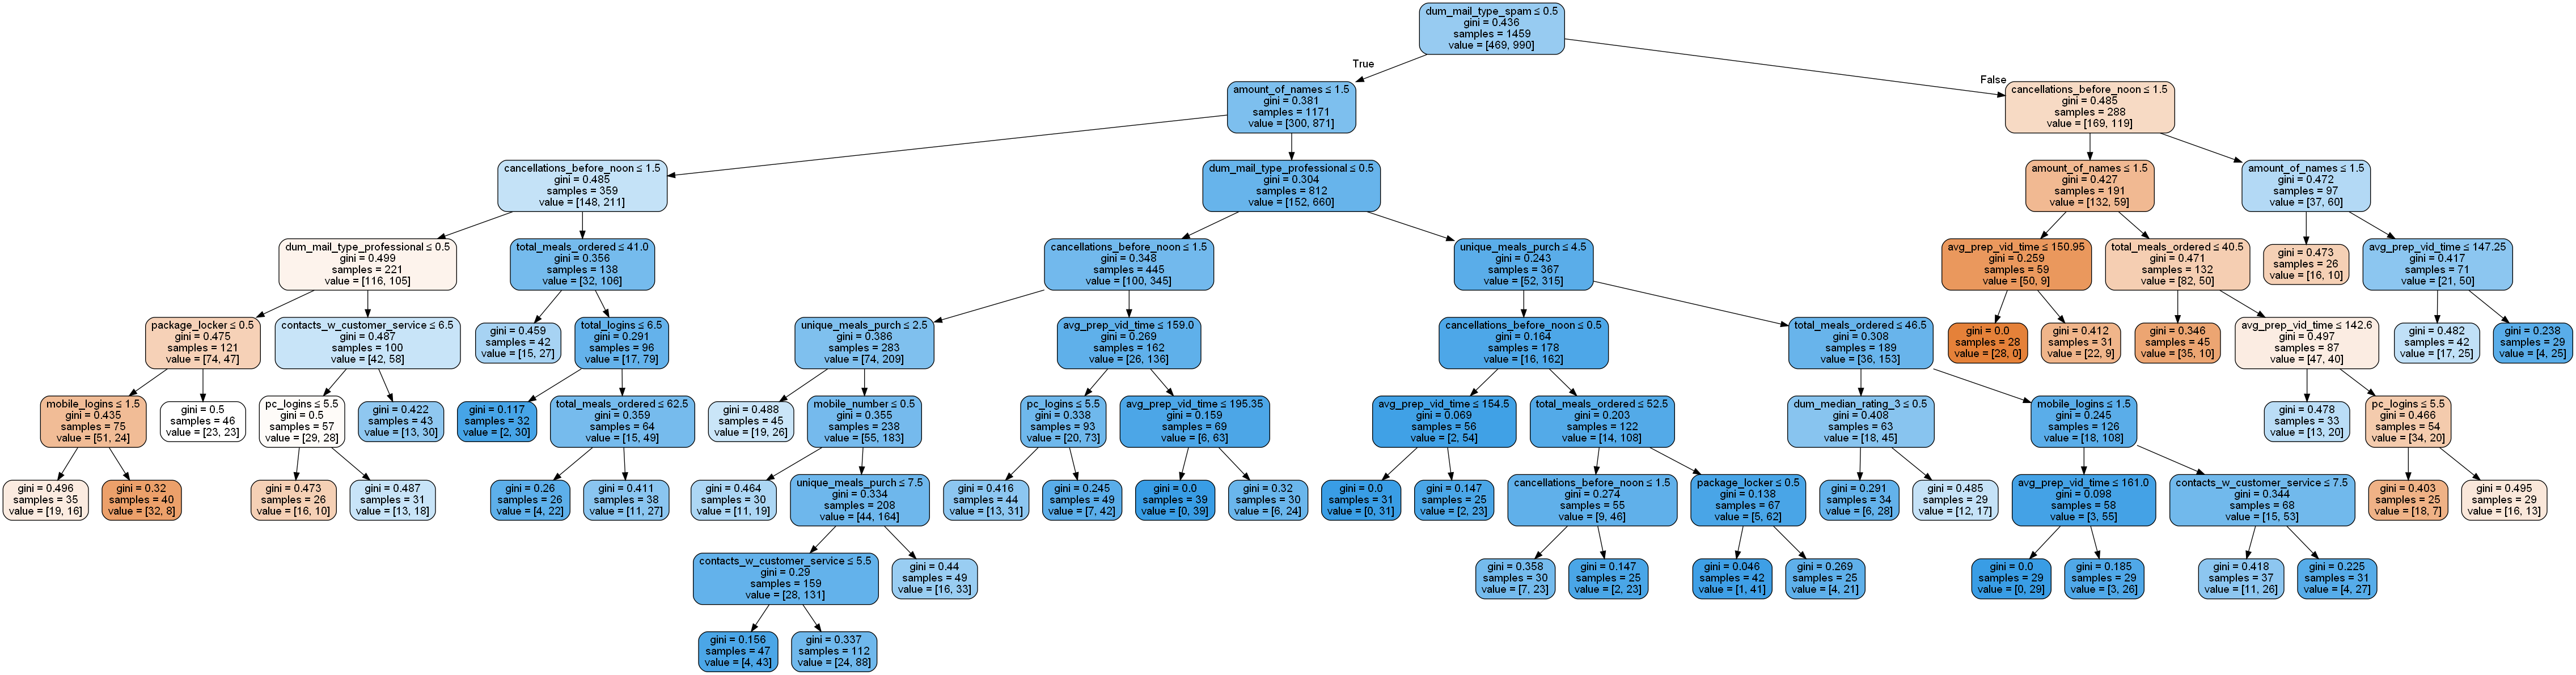

In [9]:
# calling display_tree
display_tree(tree       = full_tree_fit,
             feature_df = x_train)

In [10]:
# unpacking the confusion matrix
full_tree_tn, \
full_tree_fp, \
full_tree_fn, \
full_tree_tp = confusion_matrix(y_true = y_test, y_pred = full_tree_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {full_tree_tn}
False Positives: {full_tree_fp}
False Negatives: {full_tree_fn}
True Positives : {full_tree_tp}
""")


True Negatives : 79
False Positives: 77
False Negatives: 34
True Positives : 297



### ii) Tuning

In [11]:
# declaring a hyperparameter space
criterion_space          = ["gini", "entropy"]
splitter_space           = ["best", "random"]
max_depth_space          = pd.np.arange(1, 8, 1)
min_samples_split  = pd.np.arange(10, 600, 25)
features_space = pd.np.arange(1, 21, 1) #variables #17


# creating a hyperparameter grid
param_grid = {'criterion'          : criterion_space,
              'splitter'           : splitter_space,
              'max_depth'          : max_depth_space,
              'min_samples_split'  : min_samples_split,
              #'max_features': features_space
             }


# INSTANTIATING the model object without hyperparameters
dt_tuned = DecisionTreeClassifier(random_state = 219)


# RandomizedSearchCV object
dt_tuned_cv = RandomizedSearchCV(estimator           = dt_tuned,   # the model object
                                 param_distributions = param_grid, # parameters to tune
                                 cv                  = 3,          # how many folds in cross-validation
                                 n_iter              = 100,       # number of combinations of hyperparameters to try
                                 random_state        = 219,        # starting point for random sequence
                                 scoring = make_scorer(
                                           roc_auc_score,
                                           needs_threshold = False)) # scoring criteria (AUC)


# FITTING to the FULL DATASET (due to cross-validation)
dt_tuned_cv.fit(df_data, df_target)


# printing the optimal parameters and best score
print("Tuned Tree Parameters  :", dt_tuned_cv.best_params_)
print("Tuned Tree AUC      :", dt_tuned_cv.best_score_.round(4))

<ipython-input-11-cee577bb5771>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  max_depth_space          = pd.np.arange(1, 8, 1)
<ipython-input-11-cee577bb5771>:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  min_samples_split  = pd.np.arange(10, 600, 25)
<ipython-input-11-cee577bb5771>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  features_space = pd.np.arange(1, 21, 1) #variables #17


Tuned Tree Parameters  : {'splitter': 'best', 'min_samples_split': 285, 'max_depth': 5, 'criterion': 'gini'}
Tuned Tree AUC      : 0.689


In [12]:
dt_tuned_cv.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_split=285, random_state=219)

In [13]:
# INSTANTIATING a tree regression model with tuned values
dt_tuned = dt_tuned_cv.best_estimator_

# PREDICTING based on the testing set
dt_tuned_pred = dt_tuned.predict(x_test)


# SCORING the results
print('Tuned Tree Training Accuracy:', dt_tuned.score(x_train, y_train).round(4))

print('Tuned Tree Testing Accuracy:', dt_tuned.score(x_test, y_test).round(4))

print('Tuned Tree Gap Training/Testing:', ((dt_tuned.score(x_train, y_train))-
                                           (dt_tuned.score(x_test, y_test))).round(4))

print('Tuned AUC Score        :', roc_auc_score(y_true  = y_test,
                                  y_score = dt_tuned_pred).round(4))

# Saving for table 
fo_1 = (dt_tuned.score(x_train, y_train).round(4))

fo_2 = (dt_tuned.score(x_test, y_test).round(4))

fo_3 = (((dt_tuned.score(x_train, y_train))-(dt_tuned.score(x_test, y_test))).round(4))

fo_4 = roc_auc_score(y_true  = y_test, y_score = dt_tuned_pred).round(4)


# saving scoring data for future use
dt_tuned_train_score = dt_tuned.score(x_train, y_train).round(4) # accuracy
dt_tuned_test_score  = dt_tuned.score(x_test, y_test).round(4)   # accuracy


# saving the AUC score
lr_tuned_auc         = roc_auc_score(y_true  = y_test,
                                     y_score = dt_tuned_pred).round(4) # auc

Tuned Tree Training Accuracy: 0.7491
Tuned Tree Testing Accuracy: 0.7721
Tuned Tree Gap Training/Testing: -0.0229
Tuned AUC Score        : 0.6968


## c) Gradient Boosting Classifier

### ii) Base Model 

In [14]:
full_gbm_default = GradientBoostingClassifier(loss          = 'deviance',
                                              learning_rate = 0.1,
                                              n_estimators  = 100,
                                              criterion     = 'friedman_mse',
                                              max_depth     = 3,
                                              warm_start    = False,
                                              random_state  = 219)

# FIT step is needed as we are not using .best_estimator
full_gbm_default_fit = full_gbm_default.fit(x_train, y_train)


# PREDICTING based on the testing set
full_gbm_default_pred = full_gbm_default_fit.predict(x_test)


# SCORING the results
print('Training GBM Accuracy:', full_gbm_default_fit.score(x_train, y_train).round(4))

print('Testing GBM Accuracy :', full_gbm_default_fit.score(x_test, y_test).round(4))

print('Testing GBM Gap Training/Testing:', ((full_gbm_default_fit.score(x_train, y_train))-
                                            (full_gbm_default_fit.score(x_test, y_test))).round(4))

print('AUC GBM Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = full_gbm_default_pred).round(4))

# Saving for table 
g_1 = (full_gbm_default_fit.score(x_train, y_train).round(4))

g_2 = (full_gbm_default_fit.score(x_test, y_test).round(4))

g_3 = (((full_gbm_default_fit.score(x_train, y_train))-
                                            (full_gbm_default_fit.score(x_test, y_test))).round(4))
g_4 = (roc_auc_score(y_true  = y_test, y_score = full_gbm_default_pred).round(4))


Training GBM Accuracy: 0.8163
Testing GBM Accuracy : 0.7536
Testing GBM Gap Training/Testing: 0.0627
AUC GBM Score        : 0.673


In [15]:
# unpacking the confusion matrix
gbm_default_tn, \
gbm_default_fp, \
gbm_default_fn, \
gbm_default_tp = confusion_matrix(y_true = y_test, y_pred = full_gbm_default_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_default_tn}
False Positives: {gbm_default_fp}
False Negatives: {gbm_default_fn}
True Positives : {gbm_default_tp}
""")


True Negatives : 70
False Positives: 86
False Negatives: 34
True Positives : 297



### ii) Tuning 

In [16]:
# Tuning of GBM 
estimator_space     = np.arange(150, 200, 50)
depth_space         = np.arange(3, 4, 1)
max_features_space  = ['sqrt']
loss_space          = ['deviance']
criterion_space     = ['mse']
warm_start_space    = [True]
learn_space         = np.arange(0.4, 0.5, 0.02)

param_grid = {'max_depth'     : depth_space,
               'n_estimators'  : estimator_space,
               'loss'          : loss_space,
               'criterion'     : criterion_space,
               'max_features'  : max_features_space,
               'warm_start'    : warm_start_space,
              'learning_rate' : learn_space}


# INSTANTIATING the model object without hyperparameters
full_gbm_grid = GradientBoostingClassifier(random_state = 219)


# GridSearchCV object
full_gbm_cv = RandomizedSearchCV(estimator     = full_gbm_grid,
                           param_distributions = param_grid,
                           cv                  = 3,
                           n_iter              = 50,
                           random_state        = 219,
                           scoring             = make_scorer(roc_auc_score,
                                                 needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
full_gbm_cv.fit(df_data, df_target)


# PREDICT step is not needed


# printing the optimal parameters and best score
print("Tuned Parameters  :", full_gbm_cv.best_params_)
print("Tuned Training AUC:", full_gbm_cv.best_score_.round(4))

C:\Users\lembk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=50. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuned Parameters  : {'warm_start': True, 'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.4800000000000001, 'criterion': 'mse'}
Tuned Training AUC: 0.6336


In [17]:
full_gbm_cv.best_estimator_

GradientBoostingClassifier(criterion='mse', learning_rate=0.4800000000000001,
                           max_features='sqrt', n_estimators=150,
                           random_state=219, warm_start=True)

In [18]:
# INSTANTIATING with best_estimator
gbm_tuned = full_gbm_cv.best_estimator_


# PREDICTING based on the testing set
gbm_tuned_pred = gbm_tuned.predict(x_test)


# SCORING the results
print('Tuned GBM Training Accuracy:', gbm_tuned.score(x_train, y_train).round(4))

print('Tuned GBM Testing  Accuracy:', gbm_tuned.score(x_test, y_test).round(4))

print('Tuned GBM Gap Training/Testing:', ((gbm_tuned.score(x_train, y_train))-
                                            (gbm_tuned.score(x_test, y_test))).round(4))

print('Tuned GBM AUC Score        :', roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

# Saving for table 
gt_1 = (gbm_tuned.score(x_train, y_train).round(4))

gt_2 = (gbm_tuned.score(x_test, y_test).round(4))

gt_3 = (((gbm_tuned.score(x_train, y_train))-(gbm_tuned.score(x_test, y_test))).round(4))

gt_4 = (roc_auc_score(y_true  = y_test,
                                          y_score = gbm_tuned_pred).round(4))

Tuned GBM Training Accuracy: 0.9013
Tuned GBM Testing  Accuracy: 0.922
Tuned GBM Gap Training/Testing: -0.0207
Tuned GBM AUC Score        : 0.8918


In [19]:
# unpacking the confusion matrix
gbm_tuned_tn, \
gbm_tuned_fp, \
gbm_tuned_fn, \
gbm_tuned_tp = confusion_matrix(y_true = y_test, y_pred = gbm_tuned_pred).ravel()


# printing each result one-by-one
print(f"""
True Negatives : {gbm_tuned_tn}
False Positives: {gbm_tuned_fp}
False Negatives: {gbm_tuned_fn}
True Positives : {gbm_tuned_tp}
""")


True Negatives : 126
False Positives: 30
False Negatives: 8
True Positives : 323



## 3) Results

### a) Overview

In [20]:
print(f"""FINAL RESULTS OVERVIEW""")


print(f"""
Model      Train Score      Test Score      Gap             AUC
-----      -----------      ----------      ----------      ----------
Forest        {ft_1}           {ft_2}          {ft_3}          {ft_4}  
Tuned Forest  {fo_1}           {fo_2}          {fo_3}          {fo_4}
GBM           {g_1}            {g_2}           {g_3}           {g_4}
Tuned GBM      {gt_1}           {gt_2}          {gt_3}          {gt_4}
""")

FINAL RESULTS OVERVIEW

Model      Train Score      Test Score      Gap             AUC
-----      -----------      ----------      ----------      ----------
Forest        0.7601           0.7721          -0.012          0.7018  
Tuned Forest  0.7491           0.7721          -0.0229          0.6968
GBM           0.8163            0.7536           0.0627           0.673
Tuned GBM      0.9013           0.922          -0.0207          0.8918



<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

 <font color='red' size="100"> Final Model: GBM Tuned </font>
 
<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

### b) GBM Tuned

In [21]:
print(f"""
Metric           Score     
-----         ----------- 
Train Score     {gt_1}
Test Score      {gt_2} 
Gap Scores      {gt_3}
AUC             {gt_4}
True Negatives     {gbm_tuned_tn}
False Positives    {gbm_tuned_fp}
False Negatives    {gbm_tuned_fn}
True Positives     {gbm_tuned_tp}
""")


Metric           Score     
-----         ----------- 
Train Score     0.9013
Test Score      0.922 
Gap Scores      -0.0207
AUC             0.8918
True Negatives     126
False Positives    30
False Negatives    8
True Positives     323



#### i) Matrix

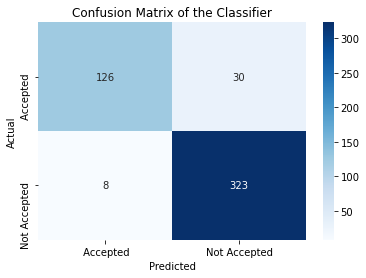

In [22]:
visual_cm(true_y = y_test,
         pred_y = gbm_tuned_pred,
         labels = [' Accepted','Not Accepted'])